# **Data description**

**price**    price in US dollars (\$326--\$18,823)

**carat**    weight of the diamond (0.2--5.01)

**cut**      quality of the cut (Fair, Good, Very Good, Premium, Ideal)

**color**    diamond color, from J (worst) to D (best)

**clarity**   a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1,               IF (best))

**x**        length in mm (0--10.74)

**y**        width in mm (0--58.9)

**z**        depth in mm (0--31.8)

**depth**    total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

**table**    width of the top of diamond relative to widest point (43--95)

# **Importing required packages**

In [1]:
# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import the packeges 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.compose import ColumnTransformer

In [3]:
#Reading the data into python
data_train = pd.read_csv('../input/shai-club/train.csv')
data_test = pd.read_csv('../input/shai-club/test.csv')

In [4]:
submit_data=data_test

In [5]:
print(len(data_train) , len(data_test))


43152 10788


In [6]:
data_train.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [7]:
data_test.head()

,Id,carat,cut,color,clarity,depth,table,x,y,z
0,1,0.34,Ideal,G,VVS2,61.1,57.0,4.52,4.48,2.75
1,2,0.71,Premium,E,VS2,62.7,58.0,5.74,5.68,3.58
2,3,0.44,Very Good,I,VS1,62.8,56.0,4.83,4.88,3.05
3,4,0.81,Premium,E,SI2,60.1,59.0,6.09,6.03,3.65
4,5,0.40,Ideal,G,VVS1,61.2,56.0,4.74,4.80,2.92


#  **Exploratory data analysis**

In [8]:
#get information about the data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [9]:
#checking the missing value for the training data
data_train.isna().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [10]:
#checking the missing value for the testing data 
data_test.isna().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [11]:
# Looking at the descriptive statistics of the data
data_train.describe(include='all')

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152,43152,43152,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
unique,NaN,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,17203,9060,10428,NaN,NaN,NaN,NaN,NaN,NaN
mean,21576.500000,0.797855,NaN,NaN,NaN,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,NaN,NaN,NaN,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,NaN,NaN,NaN,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,NaN,NaN,NaN,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,NaN,NaN,NaN,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,NaN,NaN,NaN,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000


# **Data Visualization** 

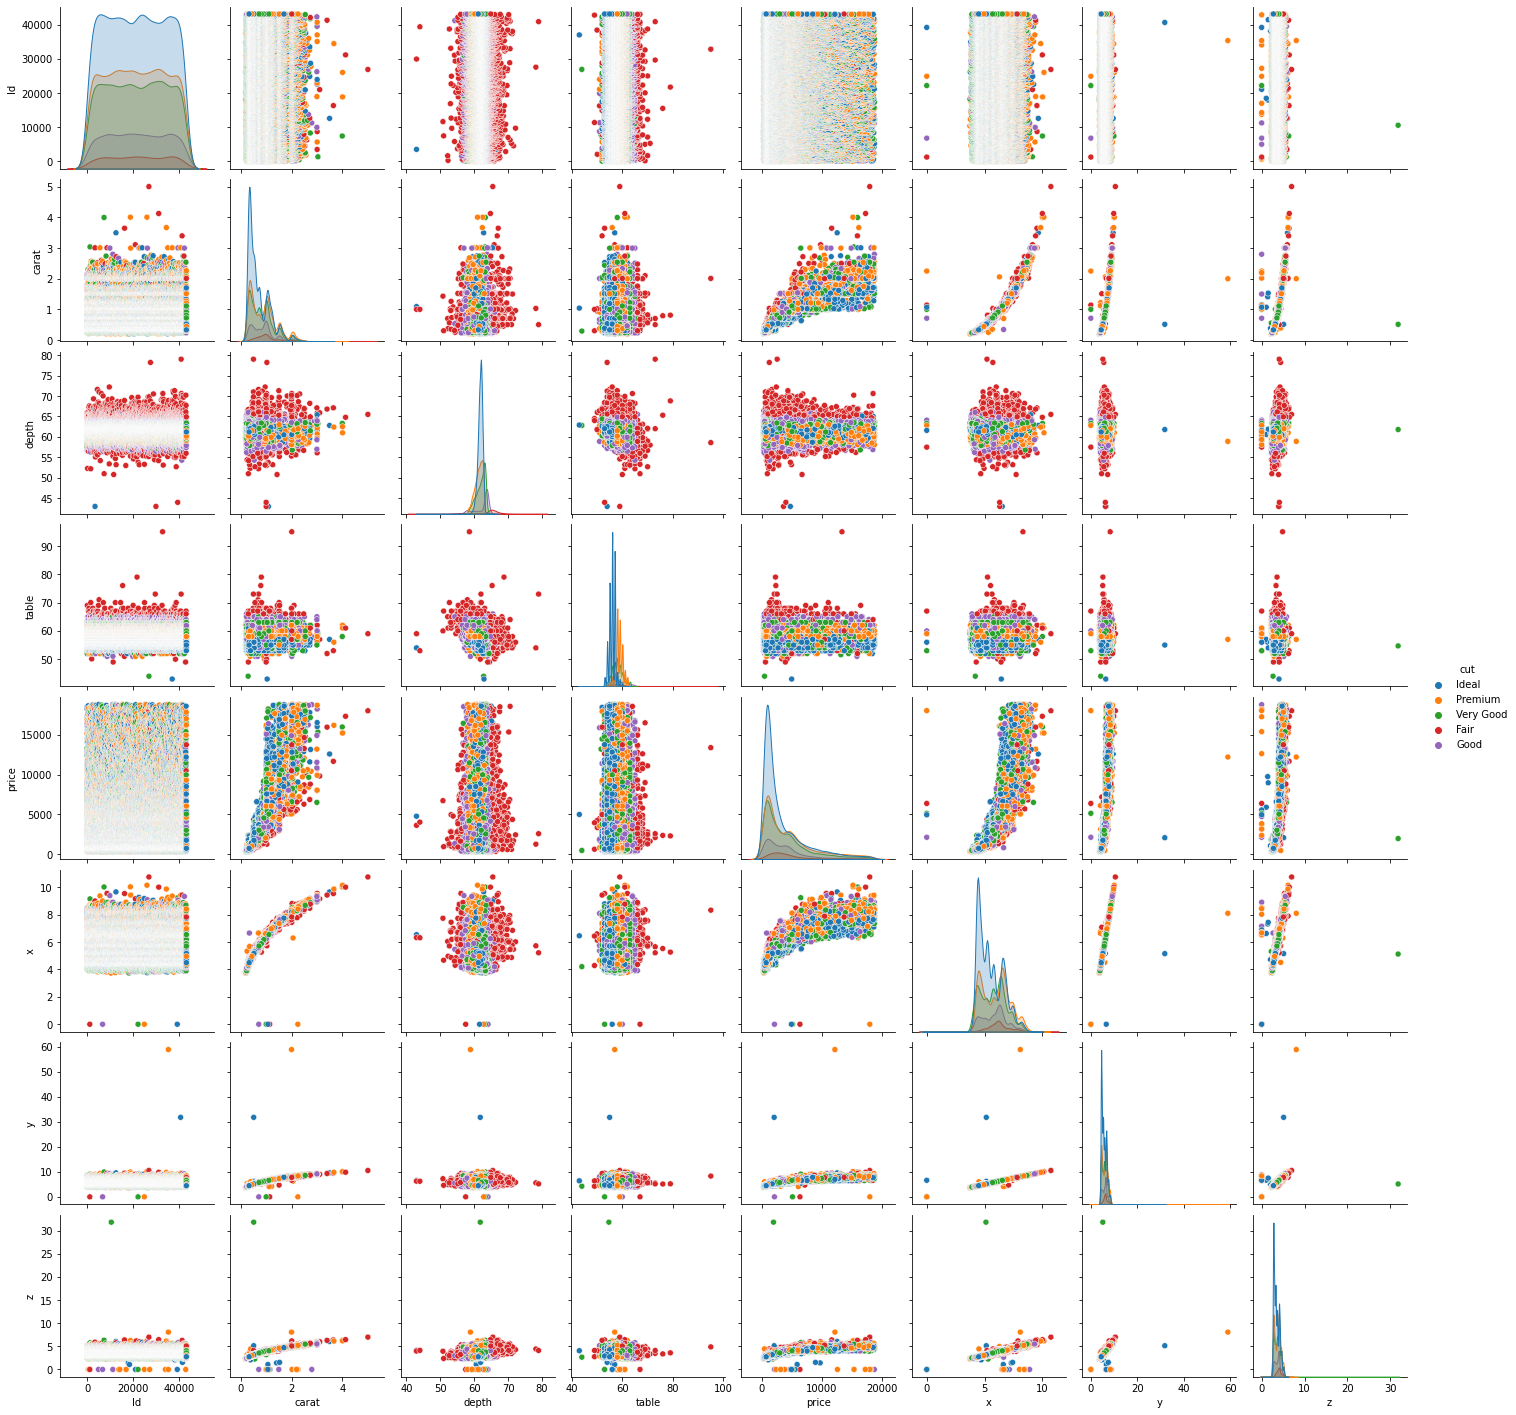

In [12]:

ax = sns.pairplot(data_train, hue= "cut")

In [13]:
data_train = data_train.drop(['Id'], axis=1)
data_test= data_test.drop(['Id'], axis=1)

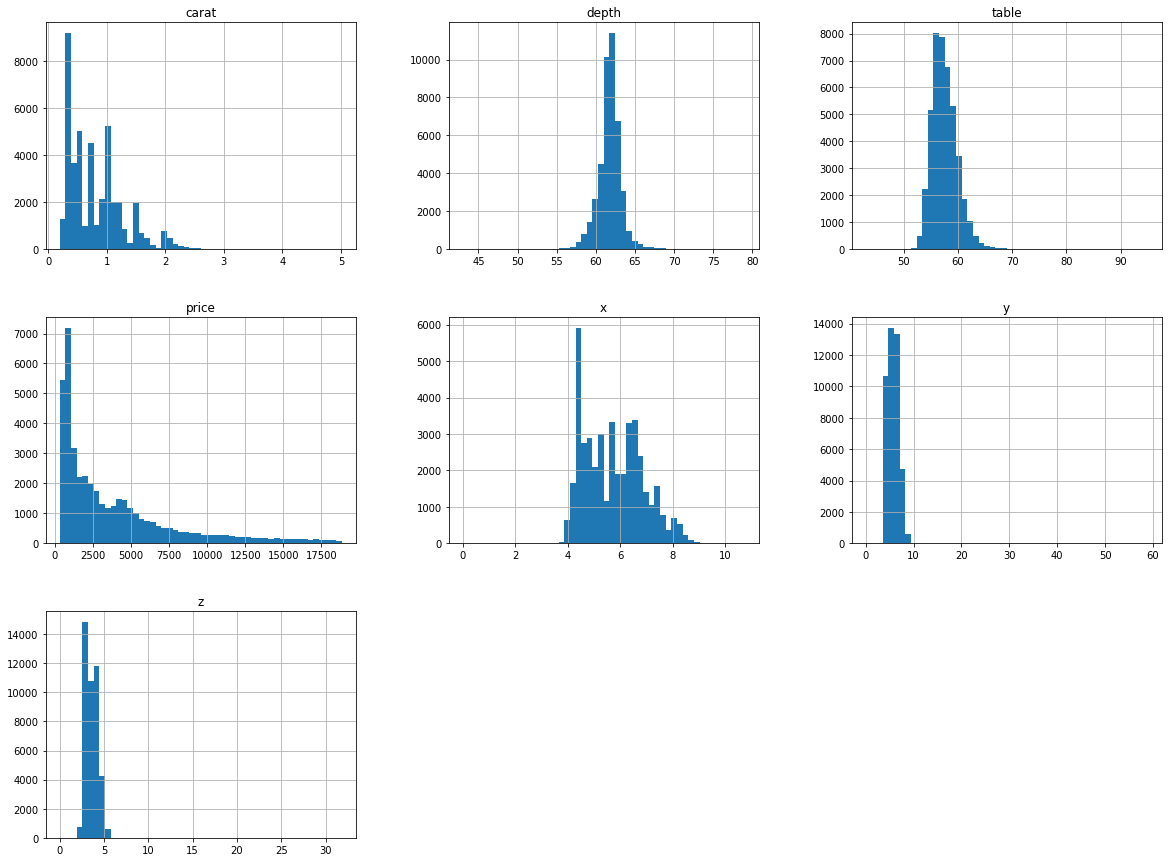

In [14]:
data_train.hist(figsize = (20,15),bins = 50)
plt.show()

In [15]:
linear_vars = data_train.select_dtypes(include=[np.number]).columns
cat_attribs = list(data_train.select_dtypes(exclude=[np.number]).columns)

In [16]:
print(linear_vars)
print(cat_attribs)

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')
['cut', 'color', 'clarity']


<Figure size 1296x648 with 0 Axes>

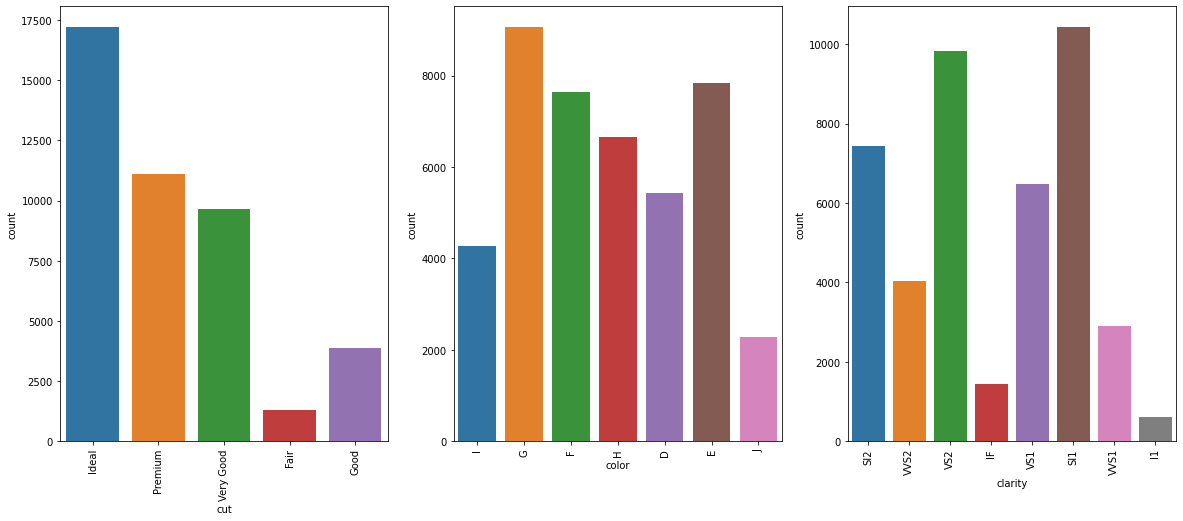

In [17]:

fig = plt.figure(figsize=(18, 9))

fig, ax = plt.subplots(1, 3, figsize=(20, 8))
for variable, subplot in zip(cat_attribs, ax.flatten()):
    sns.countplot(data_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [18]:
def plot_boxplot(df, ft):
    sns.boxplot(df[ft])
    

<Figure size 1296x648 with 0 Axes>

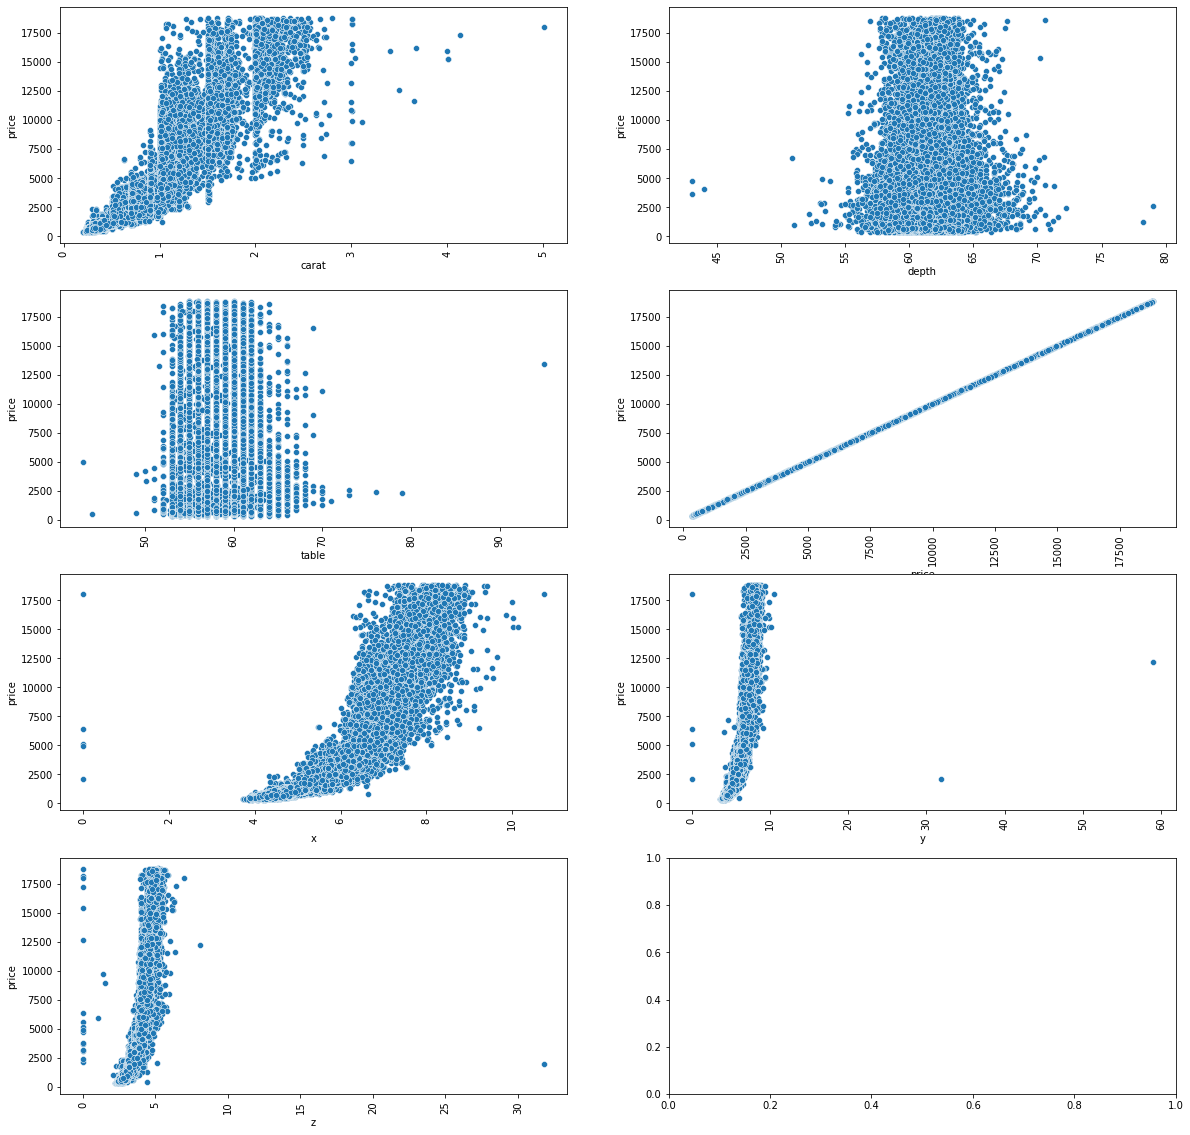

In [19]:
fig = plt.figure(figsize=(18, 9))

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for variable, subplot in zip(linear_vars, ax.flatten()):
    sns.scatterplot(x=data_train[variable],y=data_train['price'], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

<Figure size 1296x648 with 0 Axes>

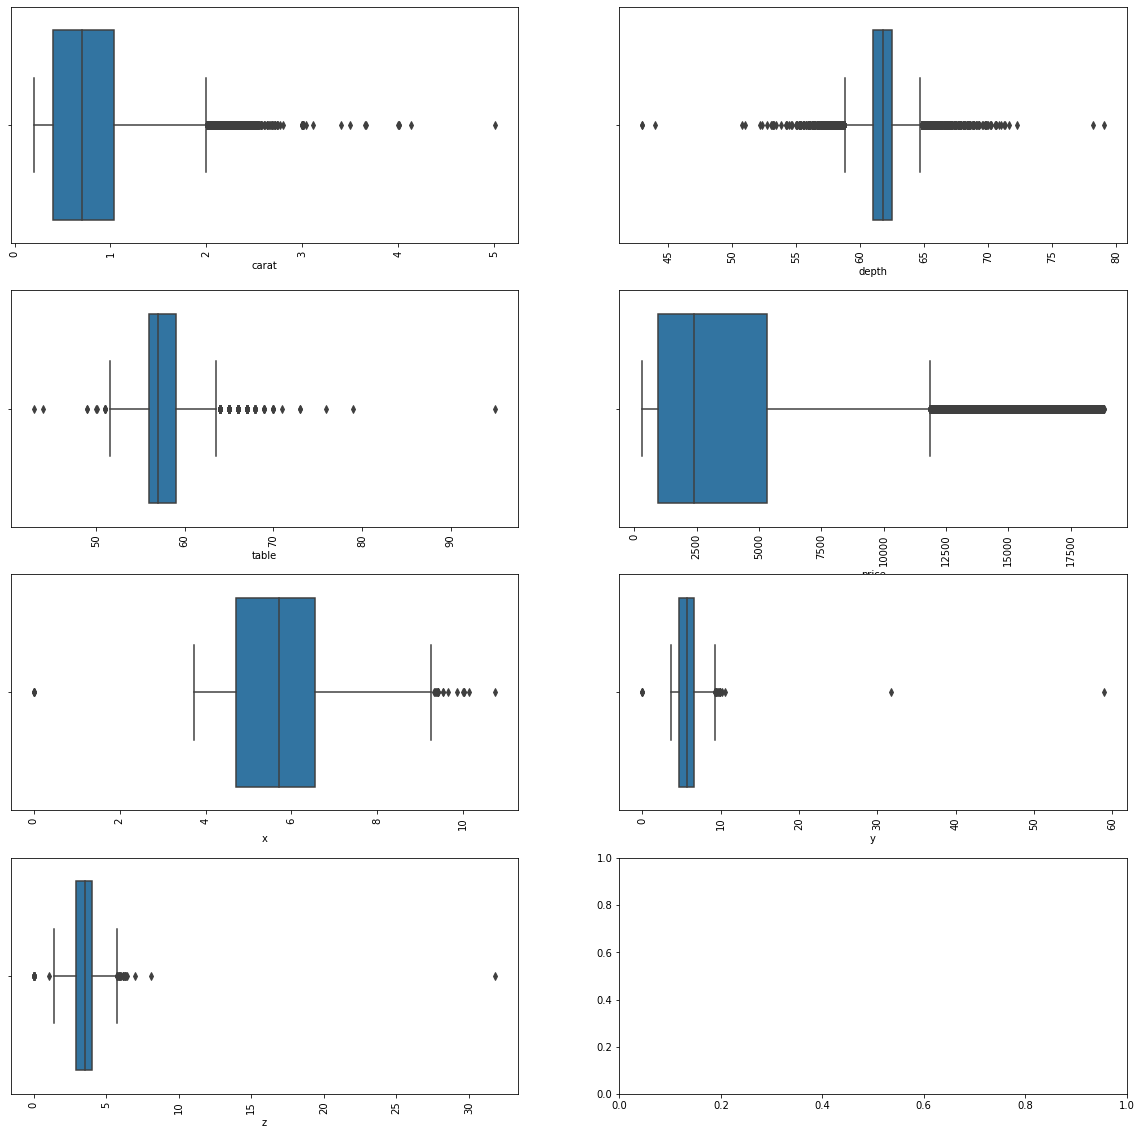

In [20]:
fig = plt.figure(figsize=(18, 9))

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for variable, subplot in zip(linear_vars, ax.flatten()):
    sns.boxplot(x=data_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

# ****remove outliers****

In [21]:
#define function to remove outliers
def  outliers(df , ft ):
    
    Q1=df[ft].quantile(0.25)
    Q3=df[ft].quantile(0.75)
    IQR=Q3 - Q1
    # Upper bound
    upper = Q3+1.5*IQR
    # Lower bound
    lower = Q1-1.5*IQR

    ls=df.index[(df[ft] < lower) | (df[ft] > upper)]
    return ls 
    


In [22]:
#create empty list to store the list index

index_list=[]
for feature in linear_vars :
    index_list.extend(outliers(data_train , feature ))

In [23]:
len(index_list)

6955

In [24]:
def remove(df, ls):
    ls=sorted(set(ls))
    df=df.drop(ls)
    return df

In [25]:
data_train= remove(data_train , index_list)

In [26]:
data_train.shape

(37993, 10)

<Figure size 1296x648 with 0 Axes>

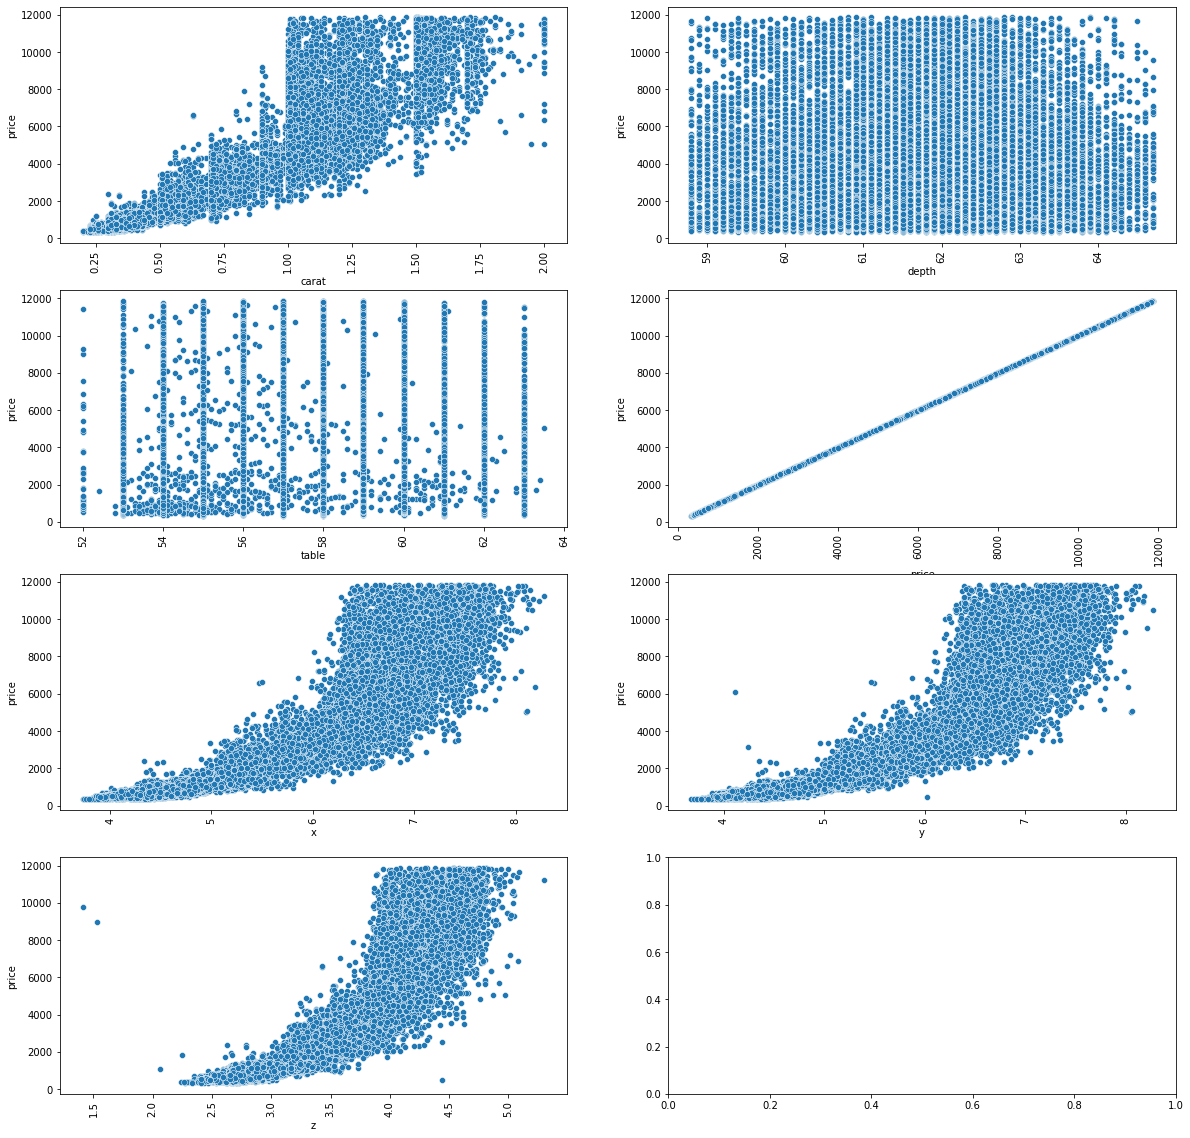

In [27]:
fig = plt.figure(figsize=(18, 9))

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for variable, subplot in zip(linear_vars, ax.flatten()):
    sns.scatterplot(x=data_train[variable],y=data_train['price'], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

<Figure size 1296x648 with 0 Axes>

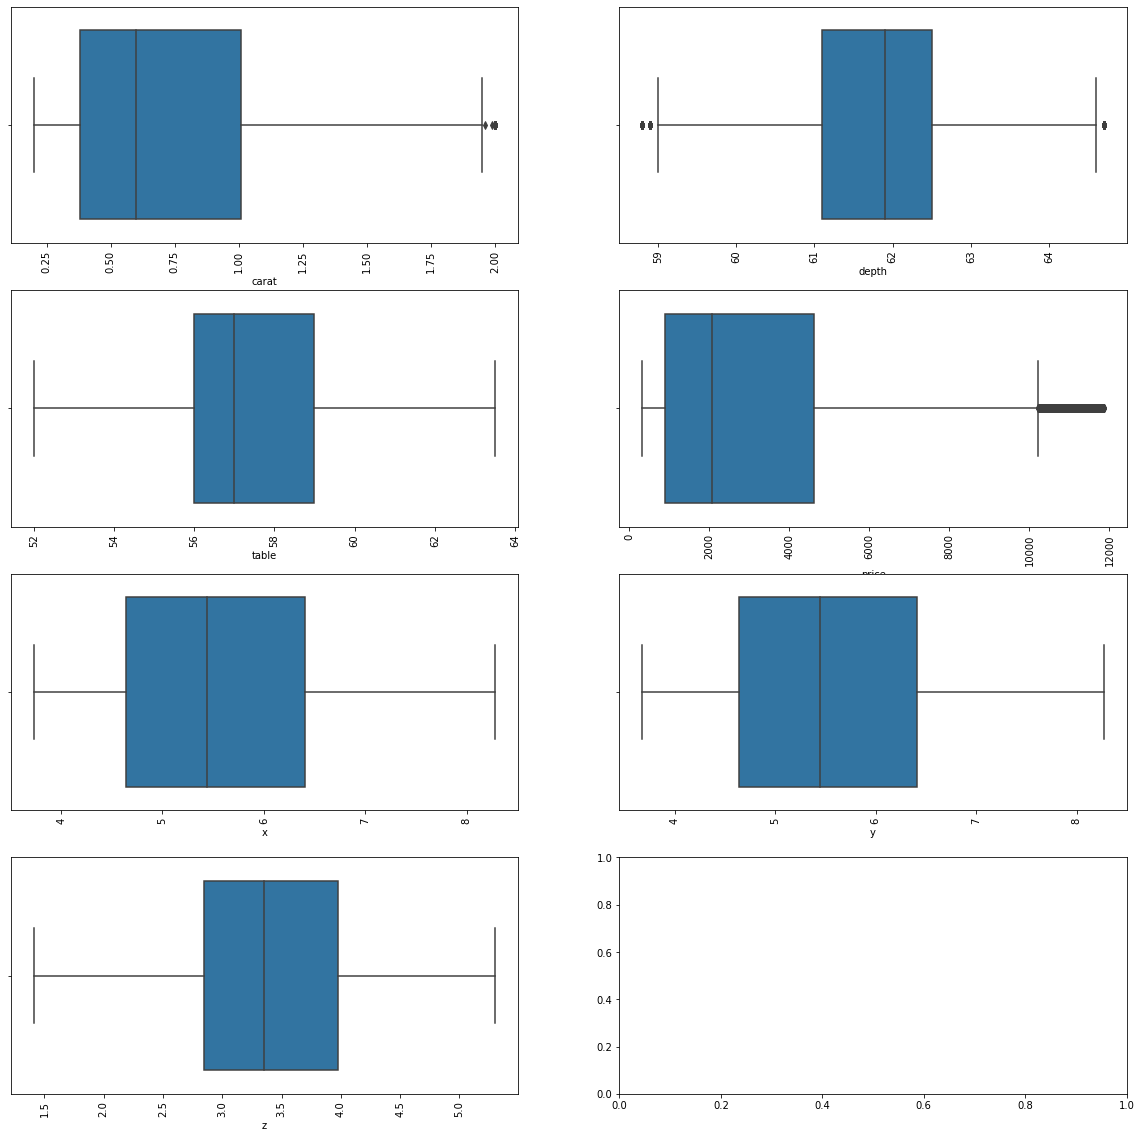

In [28]:
fig = plt.figure(figsize=(18, 9))

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for variable, subplot in zip(linear_vars, ax.flatten()):
    sns.boxplot(x=data_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

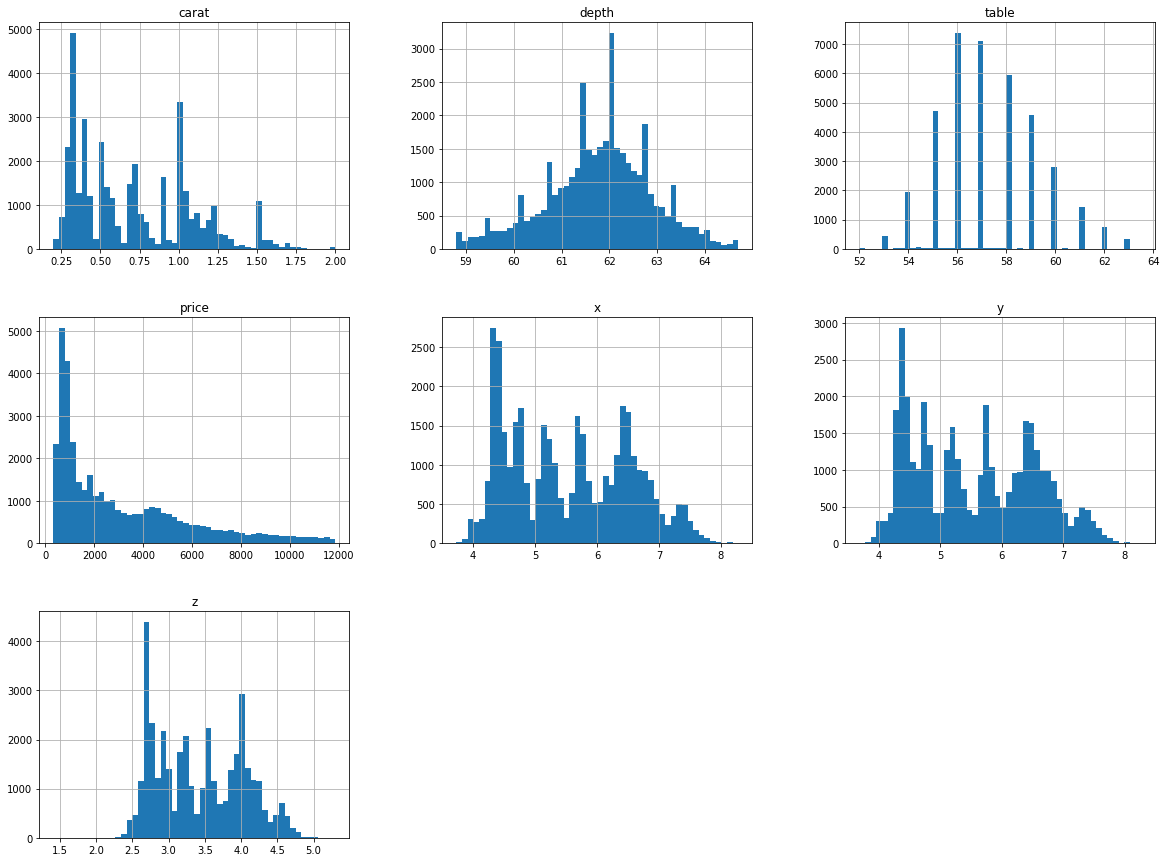

In [29]:
data_train.hist(figsize = (20,15),bins = 50)
plt.show()

In [30]:
data_train.head(20)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
2,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50
5,0.90,Very Good,G,IF,63.1,58.0,5670,6.18,6.09,3.87
6,0.71,Very Good,F,VS1,61.8,60.0,3017,5.66,5.70,3.51
7,0.70,Ideal,F,SI1,61.3,57.0,2288,5.72,5.77,3.52
8,0.59,Ideal,D,VS1,60.9,56.0,2175,5.39,5.44,3.30
9,0.31,Very Good,G,VVS1,59.8,62.0,761,4.35,4.41,2.62
10,0.43,Ideal,E,SI1,61.2,56.2,803,4.87,4.89,2.99


In [31]:
data_test.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.34,Ideal,G,VVS2,61.1,57.0,4.52,4.48,2.75
1,0.71,Premium,E,VS2,62.7,58.0,5.74,5.68,3.58
2,0.44,Very Good,I,VS1,62.8,56.0,4.83,4.88,3.05
3,0.81,Premium,E,SI2,60.1,59.0,6.09,6.03,3.65
4,0.40,Ideal,G,VVS1,61.2,56.0,4.74,4.80,2.92


# **Feature Selection & Data Split**

In [32]:
data_train.corr()['price'].sort_values(ascending = False)

price    1.000000
carat    0.922558
y        0.900714
x        0.899438
z        0.896140
table    0.137282
depth    0.004136
Name: price, dtype: float64

<AxesSubplot:>

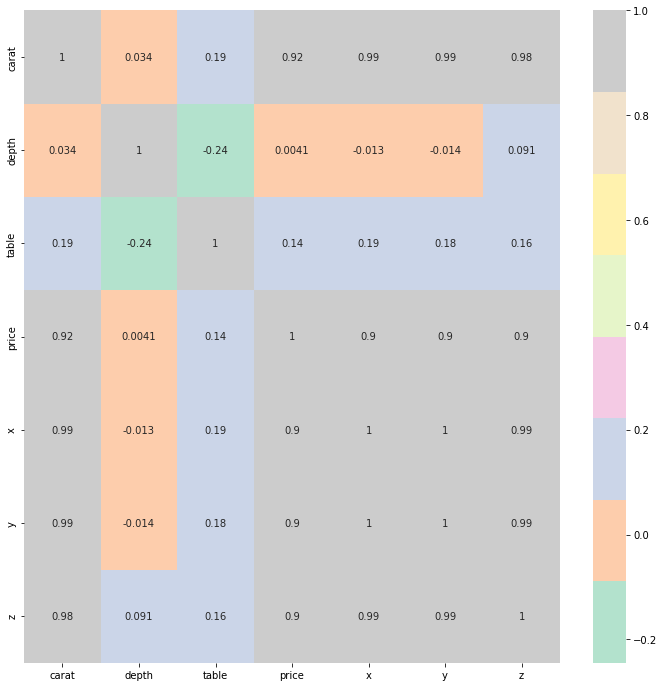

In [33]:
corrmat= data_train.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap="Pastel2",annot=True)

In [34]:
data_train['volum']=data_train['y']* data_train['x']*data_train['z']
data_train = data_train.drop(['x','y','z'], axis=1)

In [35]:
data_test['volum']=data_test['y']* data_test['x']*data_test['z']
data_test = data_test.drop(['x','y','z'], axis=1)

<AxesSubplot:>

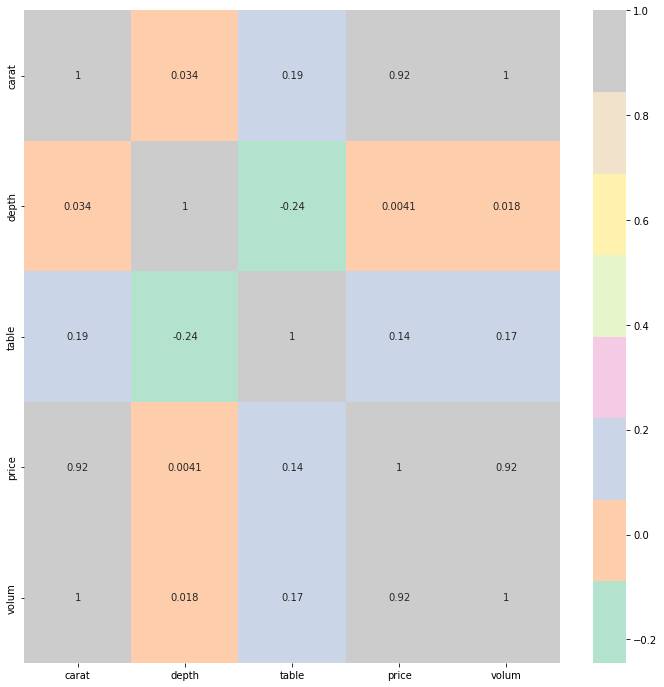

In [36]:
corrmat= data_train.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap="Pastel2",annot=True)

In [37]:
data_train.head()

,carat,cut,color,clarity,depth,table,price,volum
0,1.06,Ideal,I,SI2,61.8,57.0,4270,176.483340
2,0.32,Ideal,F,VS2,61.3,56.0,828,52.943373
3,0.53,Ideal,G,VS2,61.2,56.0,1577,86.422842
4,0.70,Premium,H,VVS2,61.0,57.0,2596,115.315200
5,0.90,Very Good,G,IF,63.1,58.0,5670,145.652094


In [38]:
X= data_train.drop(["price"],axis =1)
y= data_train["price"]

In [39]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

In [40]:
linear_vars=linear_vars

In [41]:
numeric_features = data_train.select_dtypes(include=['int64', 'float64']).drop(['price'], axis=1).columns
categorical_features = data_train.select_dtypes(include=['object']).columns
categorical_features

Index(['cut', 'color', 'clarity'], dtype='object')

In [42]:
numeric_features

Index(['carat', 'depth', 'table', 'volum'], dtype='object')

In [43]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [44]:
#split the data for training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=7)

# **Modeling**

In [45]:

# Building pipelins of  processor and model for varios regressors.

#pipline for linear regression model
pipeline_lr=Pipeline([("preprocessor",preprocessor),
                     ("lr_reg",LinearRegression())])

#pipline for Decision Tree Regressor
pipeline_dt=Pipeline([("preprocessor",preprocessor),
                     ("dt_reg",DecisionTreeRegressor())])

#pipline for Random Forest Regressor/
pipeline_rf=Pipeline([("preprocessor",preprocessor),
                     ("rf_reg",RandomForestRegressor())])


#pipline for KNeighbors Regressor
pipeline_kn=Pipeline([("preprocessor",preprocessor),
                     ("rf_reg",KNeighborsRegressor())])

#pipline for Suport Vector  Regressor
pipeline_svm=Pipeline([("preprocessor",preprocessor),
                     ("svm_reg",SVR())])





In [46]:
# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_svm ]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "Support Vector"}


In [47]:
# Fit  all  pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [48]:

cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=5)
    cv_results_rms.append(cv_score)
    print("%s : %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression : -770.540354 
DecisionTree : -509.804207 
RandomForest : -380.904332 
KNeighbors : -596.524775 
Support Vector : -1902.220688 


In [49]:
pred = pipeline_rf.predict(X_test)
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.9821205377127818
Adjusted R^2: 0.9821073508793596
MAE: 211.21052417593285
MSE: 133758.79185322818
RMSE: 365.73049073495116


# **Fine-Tune Your Model**

In [50]:
from sklearn.model_selection import GridSearchCV


In [51]:
param_grid = { 
    'rf_reg__n_estimators': [200, 500],
    'rf_reg__max_features': ['auto', 'sqrt', 'log2'],
    'rf_reg__max_depth' : [4,5,6,7,8]}
grid_search = GridSearchCV(pipeline_rf,param_grid,cv = 10, scoring = 'neg_mean_squared_error',return_train_score = True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['carat', 'depth', 'table', 'volum'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         Index(['cut', 'color', 'clarity'], dtype='object'))])),
                                       ('rf_reg', RandomForestRegressor())]),
 

In [52]:
data_train.head()

,carat,cut,color,clarity,depth,table,price,volum
0,1.06,Ideal,I,SI2,61.8,57.0,4270,176.483340
2,0.32,Ideal,F,VS2,61.3,56.0,828,52.943373
3,0.53,Ideal,G,VS2,61.2,56.0,1577,86.422842
4,0.70,Premium,H,VVS2,61.0,57.0,2596,115.315200
5,0.90,Very Good,G,IF,63.1,58.0,5670,145.652094


In [53]:
search_score = cross_val_score(grid_search,
                               X_train,
                               y_train,
                               scoring="neg_mean_squared_error",
                               cv=10)
search_rmse_score=np.sqrt(-search_score)
print("Scores: ", search_rmse_score)
print("Mean: ", search_rmse_score.mean())
print("Standard Deviation: ", search_rmse_score.std())

Scores:  [568.54050618 566.46742993 566.25062433 592.07193688 564.61131298
 584.31067432 604.63478364 582.36022874 579.69930012 577.35560728]
Mean:  578.6302404406597
Standard Deviation:  12.26941363565007


# Analyze the Best Models and Their Errors

In [54]:
grid_search.best_params_

{'rf_reg__max_depth': 8,
 'rf_reg__max_features': 'auto',
 'rf_reg__n_estimators': 500}

In [55]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
  print(np.sqrt(-mean_score), params)

870.0364721419251 {'rf_reg__max_depth': 4, 'rf_reg__max_features': 'auto', 'rf_reg__n_estimators': 200}
869.0238695365704 {'rf_reg__max_depth': 4, 'rf_reg__max_features': 'auto', 'rf_reg__n_estimators': 500}
1284.9961013777738 {'rf_reg__max_depth': 4, 'rf_reg__max_features': 'sqrt', 'rf_reg__n_estimators': 200}
1293.3935343998262 {'rf_reg__max_depth': 4, 'rf_reg__max_features': 'sqrt', 'rf_reg__n_estimators': 500}
1286.8440946806447 {'rf_reg__max_depth': 4, 'rf_reg__max_features': 'log2', 'rf_reg__n_estimators': 200}
1290.1854923674002 {'rf_reg__max_depth': 4, 'rf_reg__max_features': 'log2', 'rf_reg__n_estimators': 500}
782.7791053303506 {'rf_reg__max_depth': 5, 'rf_reg__max_features': 'auto', 'rf_reg__n_estimators': 200}
781.5892827852192 {'rf_reg__max_depth': 5, 'rf_reg__max_features': 'auto', 'rf_reg__n_estimators': 500}
1125.605157502315 {'rf_reg__max_depth': 5, 'rf_reg__max_features': 'sqrt', 'rf_reg__n_estimators': 200}
1123.683658808783 {'rf_reg__max_depth': 5, 'rf_reg__max_feat

# Evaluate Your Model

In [56]:
data_test.head()

,carat,cut,color,clarity,depth,table,volum
0,0.34,Ideal,G,VVS2,61.1,57.0,55.686400
1,0.71,Premium,E,VS2,62.7,58.0,116.719456
2,0.44,Very Good,I,VS1,62.8,56.0,71.889720
3,0.81,Premium,E,SI2,60.1,59.0,134.037855
4,0.40,Ideal,G,VVS1,61.2,56.0,66.435840


In [57]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

555.6511235256585

# compute a 95% confidence interval for the generalization error 

In [58]:
from scipy import stats


In [59]:
# CODE HERE
confidance=0.95

squared_errors=(final_predictions - y_test) ** 2 
np.sqrt(stats.t.interval
          (
              confidance ,
              len(squared_errors) -1 ,
              loc=squared_errors.mean(),
              scale=stats.sem(squared_errors)
           )
          )

array([536.64138426, 574.03167756])

In [60]:
data_test.head()

,carat,cut,color,clarity,depth,table,volum
0,0.34,Ideal,G,VVS2,61.1,57.0,55.686400
1,0.71,Premium,E,VS2,62.7,58.0,116.719456
2,0.44,Very Good,I,VS1,62.8,56.0,71.889720
3,0.81,Premium,E,SI2,60.1,59.0,134.037855
4,0.40,Ideal,G,VVS1,61.2,56.0,66.435840


In [61]:
data_train.head()

,carat,cut,color,clarity,depth,table,price,volum
0,1.06,Ideal,I,SI2,61.8,57.0,4270,176.483340
2,0.32,Ideal,F,VS2,61.3,56.0,828,52.943373
3,0.53,Ideal,G,VS2,61.2,56.0,1577,86.422842
4,0.70,Premium,H,VVS2,61.0,57.0,2596,115.315200
5,0.90,Very Good,G,IF,63.1,58.0,5670,145.652094


In [62]:
prediction=final_model.predict(data_test)

In [63]:
#predict the test data 
prediction

array([  732.5941897 ,  3066.62732315,   982.25712923, ...,
        3131.0168741 ,  4561.83727068, 10403.0315989 ])

# **Prepare Submission File**

In [64]:
my_submission = pd.DataFrame({'Id': submit_data.Id, 'price': prediction})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)